# 3. Extract Transforms Use Cases

In this notebook, I will show some use cases for extracting out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in a Vega Lite spec and computing them in the database instead of on the client. 


In [1]:
import altair as alt
import ibis
import omnisci_renderer

In [2]:
# enable JSON transformer so we can get more rows to altair
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Omnisci [Vega Tutorial](https://www.omnisci.com/docs/latest/6_vegaTutorials.html)

First, let's go through the omnisci vega tutorial, but doing this all client side. We will that results don't look quite right since we will only get back a subset of rows from the backend, since there are too many.

This makes the case for doing aggregates in the backend before sending the data.

In [3]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)

In [4]:
t = conn.table('tweets_nov_feb')

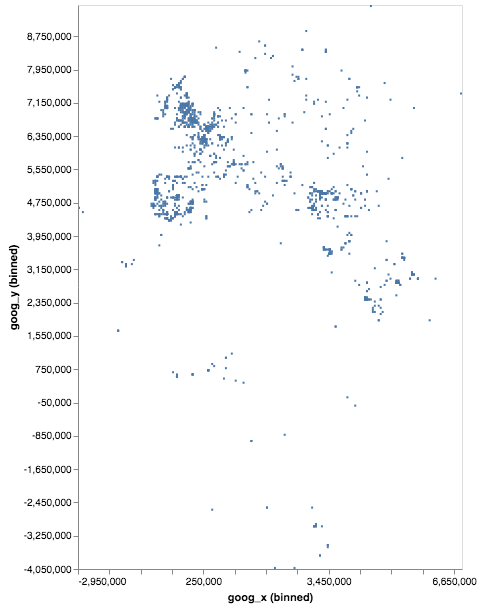

In [5]:
c = alt.Chart(t[t.goog_x, t.goog_y], width=384, height=564).mark_rect().encode(
    alt.X('goog_x:Q', bin=alt.Bin(maxbins=384)),
    alt.Y('goog_y:Q', bin=alt.Bin(maxbins=564)),
).transform_filter(
    alt.FieldRangePredicate(field='goog_x', range=[-3650484.1235206556, 7413325.514451755])
).transform_filter(
    alt.FieldRangePredicate(field='goog_y', range=[-5778161.9183506705, 10471808.487466192])
)
c

Now let's try looking at the Vega Lite produced:

In [6]:
alt.renderers.enable('json')
c

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


And then if we extract the transforms:

In [7]:
alt.renderers.enable('extract-json')
c

<IPython.core.display.JSON object>

Now it's a matter of taking those `transforms` and updating the ibis query with them, so that the filtering and binning happens on the backend

OK Now let's try it again by doing thatt:

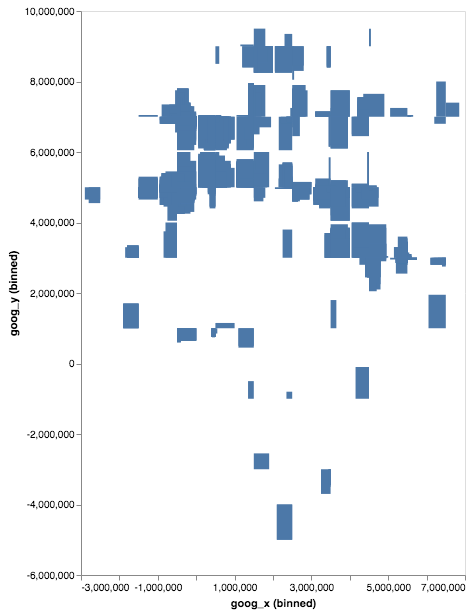

In [8]:
alt.renderers.enable('extract-ibis')
c

### "Getting More from Your Data"

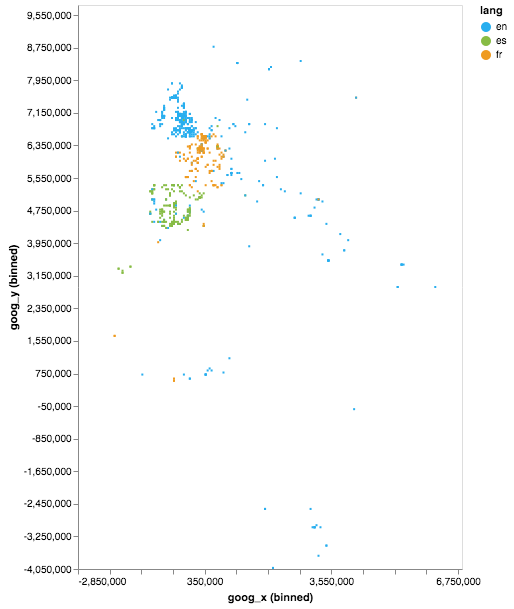

In [9]:
# can't set all to grey
# https://github.com/vega/vega-lite/issues/4255

alt.renderers.enable('default')
c = alt.Chart(t[t.goog_x, t.goog_y, t.lang], width=384, height=564).mark_rect().encode(
    alt.X('goog_x:Q', bin=alt.Bin(maxbins=384)),
    alt.Y('goog_y:Q', bin=alt.Bin(maxbins=564)),
    color=alt.Color(
        'lang',
        scale=alt.Scale(
            domain=["en",  "es", "fr"],
            range=["#27aeef", "#87bc45", "#ef9b20"],
        ),
    )
).transform_filter(
    alt.FieldRangePredicate(field='goog_x', range=[-3650484.1235206556, 7413325.514451755])
).transform_filter(
    alt.FieldRangePredicate(field='goog_y', range=[-5778161.9183506705, 10471808.487466192])
)
c

In [10]:
alt.renderers.enable('extract-json')
c


<IPython.core.display.JSON object>

### "Creating More Advanced Charts"

In [11]:
c = conn.table("contributions_donotmodify")

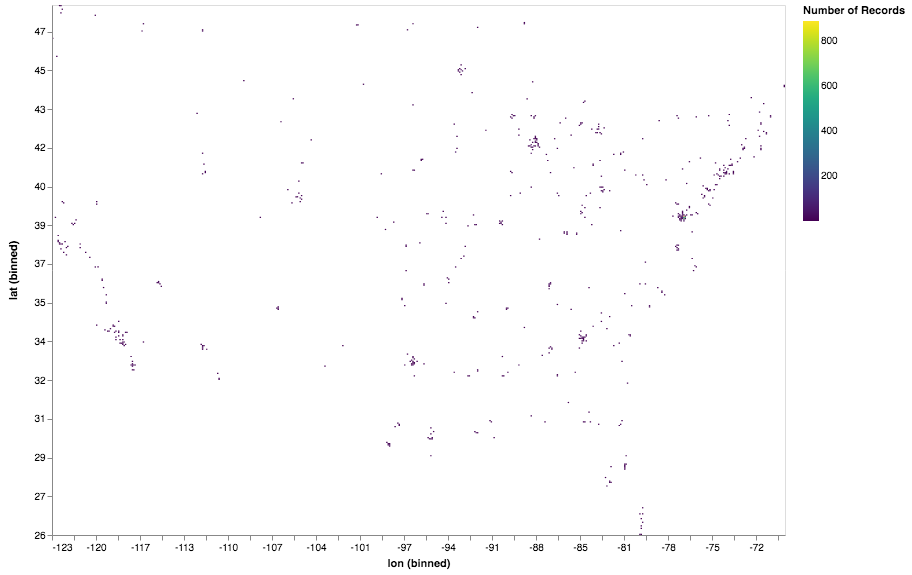

In [12]:
alt.renderers.enable('default')
c = alt.Chart(
    c[c.lon, c.lat, c.recipient_party, c.amount],
    width=733,
    height=530
).mark_rect().encode(
    alt.X('lon:Q', bin=alt.Bin(maxbins=733)),
    alt.Y('lat:Q', bin=alt.Bin(maxbins=530)),
    alt.Color('count(lon):Q')
).transform_filter(
    alt.FieldRangePredicate(field='lon', range=[-124.39000000000038, -66.93999999999943])
).transform_filter(
    alt.FieldRangePredicate(field='lat', range=[20.61570573311549, 52.93117449504004])
).transform_filter(
    alt.FieldEqualPredicate('R', 'recipient_party'),
).transform_filter(
    alt.FieldGTPredicate('amount', 0)
)
c

In [13]:
alt.renderers.enable('extract-json')
c

<IPython.core.display.JSON object>

### "Working with Polys Marks Type"

TODO: Not sure how to query poly data with ibis

## Vega Accumulator
TODO: Add https://www.omnisci.com/docs/latest/6_vegaAccumulatorExample.html examples